In [1]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

import gym
from gym import spaces
from gym.envs.toy_text.blackjack import *


plt.style.use('bmh')
env = gym.make('Blackjack-v1', natural=True)

## Часть первая, с блекджеком и стратегиями
Мы будем обучаться играть в очень простую, но знаменитую и популярную игру: блекджек.

Правила блекджека достаточно просты; давайте начнём с самой базовой версии, которая реализована в OpenAI Gym:
- численные значения карт равны от 2 до 10 для карт от двойки до десятки, 10 для валетов, дам и королей;
- туз считается за 11 очков, если общая сумма карт на руке при этом не превосходит 21 (по-английски в этом случае говорят, что на руке есть usable ace), и за 1 очко, если превосходит;
- игроку раздаются две карты, дилеру — одна в открытую и одна в закрытую;
- игрок может совершать одно из двух действий:
    + hit — взять ещё одну карту;
    + stand — не брать больше карт;
- если сумма очков у игрока на руках больше 21, он проигрывает (bust);
- если игрок выбирает stand с суммой не больше 21, дилер добирает карты, пока сумма карт в его руке меньше 17;
- после этого игрок выигрывает, если дилер либо превышает 21, либо получает сумму очков меньше, чем сумма очков у игрока; при равенстве очков объявляется ничья (ставка возвращается);
- в исходных правилах есть ещё дополнительный бонус за natural blackjack: если игрок набирает 21 очко с раздачи, двумя картами, он выигрывает не +1, а +1.5 (полторы ставки).

Именно этот простейший вариант блекджека реализован в OpenAI Gym:

### 1. Рассмотрим очень простую стратегию: говорить stand, если у нас на руках комбинация в 19, 20 или 21 очко, во всех остальных случаях говорить hit. Используйте методы Монте-Карло, чтобы оценить выигрыш от этой стратегии.

In [2]:
STAND = 0
HIT = 1

In [3]:
def dummy_policy(sum_hand):
    return STAND


def simple_policy(sum_hand):
    if sum_hand < 19:
        return HIT
    return STAND


def run_game(policy, game_len=150_000):
    result_list = []
    
    for _ in tqdm(range(game_len)):
        sum_hand = env.reset()[0]

        while policy(sum_hand) != STAND:
            sum_hand = env.step(HIT)[0][0]

        result = env.step(STAND)[1]
        result_list.append(result)
    return result_list

In [4]:
dummy_res = run_game(dummy_policy)

print(f"Dummy policy - mean reward: {np.mean(dummy_res)}")

100%|██████████| 150000/150000 [00:11<00:00, 12826.68it/s]

Dummy policy - mean reward: -0.18239333333333332


In [5]:
simple_res = run_game(simple_policy)

print(f"Simple policy - mean reward: {np.mean(simple_res)}")

100%|██████████| 150000/150000 [00:14<00:00, 10706.83it/s]

Simple policy - mean reward: -0.06076666666666666


### 2. Реализуйте метод обучения с подкреплением без модели (можно Q-обучение, но рекомендую попробовать и другие, например Monte Carlo control) для обучения стратегии в блекджеке, используя окружение Blackjack-v1 из OpenAI Gym.

In [6]:
print(f"observation_space: {env.observation_space}")
print(f"action_space: {env.action_space}")

observation_space: Tuple(Discrete(32), Discrete(11), Discrete(2))
action_space: Discrete(2)


In [7]:
NUM_S = 32 * 11 * 2
NUM_A = 2

def get_state_ind(observation):
    sum_hand, dealer_hand, usable_ace = observation
    sum_hand -= 1
    dealer_hand -= 1
    
    return sum_hand + 32 * dealer_hand + 32 * 11 * usable_ace


def q_learn_policy(Q, state_ind, epsilon):
    if np.random.rand() <= epsilon:
        return np.random.randint(NUM_A)
    
    return np.argmax(Q[state_ind])


def run_q_game(env, policy, game_len=500_000, alpha=0.01, gamma=0.9, epsilon=0.1, log_position=0):
    result_list = []
    q_possition = []
    Q = np.random.random(size=(NUM_S, NUM_A))
    
    for _ in tqdm(range(game_len)):
        reward = 0
        is_episode_end = False
        observation = env.reset()
        state_ind = get_state_ind(observation)
        
        while is_episode_end == False:
            action = policy(Q, state_ind, epsilon)
            new_observation, reward, is_episode_end, _ = env.step(action)
            new_state_ind = get_state_ind(new_observation)
            Q[state_ind][action] += alpha * (reward + gamma * max(Q[new_state_ind]) - Q[state_ind][action])
            state_ind = new_state_ind
            
        q_possition.append(np.copy(Q[log_position]))
        result_list.append(reward)
    return result_list, q_possition

In [10]:
interesting_possition = get_state_ind((21, 8, True)) # total win ;)
q_learn_res, q_position = run_q_game(
    env, q_learn_policy, game_len=500_000, alpha=0.01, gamma=0.1, epsilon=0.1, log_position=interesting_possition)

print(f"Q-learning policy - mean reward: {np.mean(q_learn_res[:-200_000])}")

100%|██████████| 500000/500000 [00:53<00:00, 9273.53it/s] 

Q-learning policy - mean reward: -0.10276666666666667


### 3. Сколько выигрывает казино у вашей стратегии? Нарисуйте графики среднего дохода вашего метода (усреднённого по крайней мере по 100000 раздач, а лучше больше) по ходу обучения. Попробуйте подобрать оптимальные гиперпараметры.

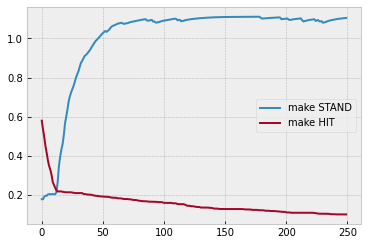

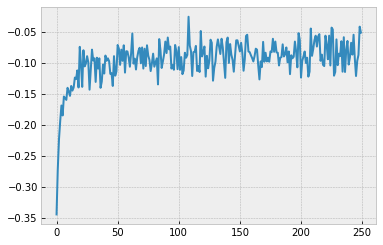

In [12]:
q_position = np.array(q_position)
plt.plot(q_position[:,0].reshape(-1, 2_000).mean(axis=1), label='make STAND')
plt.plot(q_position[:,1].reshape(-1, 2_000).mean(axis=1), label='make HIT')
plt.legend()
plt.show()

plt.plot(np.array(q_learn_res).reshape(-1, 2_000).mean(axis=1))
plt.show();

## Часть вторая, удвоенна
В базовый блекджек, описанный в предыдущем разделе, обыграть казино вряд ли получится. Но, к счастью, на этом история не заканчивается. Описанные выше правила были упрощёнными, а на самом деле у игрока есть ещё и другие возможности. Реализовывать split может оказаться непросто, поэтому давайте ограничимся удвоением ставки. Итак, у игрока появляется дополнительное действие:
- double — удвоить ставку; при этом больше действий делать нельзя, игроку выдаётся ровно одна дополнительная карта, а выигрыш или проигрыш удваивается.

### 4. Реализуйте новый вариант блекджека на основе окружения Blackjack-v0 из OpenAI Gym, в котором разрешено удвоение ставки.

In [13]:
NUM_A = 3


class BlackjackWithDoubleEnv(BlackjackEnv):
    def __init__(self):
        super().__init__()
        self.action_space = spaces.Discrete(NUM_A) # MY CODE: new action here
        self.reset()

    def step(self, action):
        assert self.action_space.contains(action)
        if action == 1:  # hit: add a card to players hand and return
            self.player.append(draw_card(self.np_random))
            if is_bust(self.player):
                done = True
                reward = -1.0
            else:
                done = False
                reward = 0.0
        elif action == 2:   # MY CODE: new action here
            self.player.append(draw_card(self.np_random))   # MY CODE: new action here
            done = True
            if is_bust(self.player):
                reward = -1.0
            else:
                while sum_hand(self.dealer) < 17:
                    self.dealer.append(draw_card(self.np_random))
                reward = cmp(score(self.player), score(self.dealer))
                if self.sab and is_natural(self.player) and not is_natural(self.dealer):
                    # Player automatically wins. Rules consistent with S&B
                    reward = 1.0
                elif (
                    not self.sab
                    and self.natural
                    and is_natural(self.player)
                    and reward == 1.0
                ):
                    # Natural gives extra points, but doesn't autowin. Legacy implementation
                    reward = 1.5
            reward *= 2.0   # MY CODE: new action here
        else:  # stick: play out the dealers hand, and score
            done = True
            while sum_hand(self.dealer) < 17:
                self.dealer.append(draw_card(self.np_random))
            reward = cmp(score(self.player), score(self.dealer))
            if self.sab and is_natural(self.player) and not is_natural(self.dealer):
                # Player automatically wins. Rules consistent with S&B
                reward = 1.0
            elif (
                not self.sab
                and self.natural
                and is_natural(self.player)
                and reward == 1.0
            ):
                # Natural gives extra points, but doesn't autowin. Legacy implementation
                reward = 1.5
        return self._get_obs(), reward, done, {}

In [14]:
double_env = BlackjackWithDoubleEnv()

### 5. Реализуйте метод обучения с подкреплением без модели для этого варианта, постройте графики, аналогичные п.2.

In [15]:
interesting_possition = get_state_ind((11, 8, False))
q_learn_res, q_position = run_q_game(
    double_env, q_learn_policy, game_len=500_000, alpha=0.01, gamma=0.1, epsilon=0.05, log_position=interesting_possition)

print(f"Q-learning policy - mean reward: {np.mean(q_learn_res[:-200_000])}")

100%|██████████| 500000/500000 [00:55<00:00, 9033.85it/s] 


Q-learning policy - mean reward: -0.10812


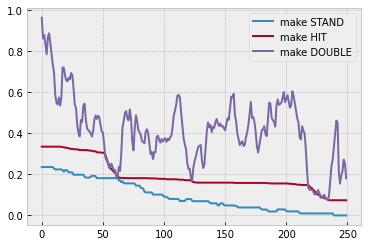

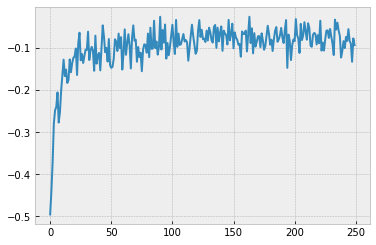

In [16]:
q_position = np.array(q_position)
plt.plot(q_position[:,0].reshape(-1, 2_000).mean(axis=1), label='make STAND')
plt.plot(q_position[:,1].reshape(-1, 2_000).mean(axis=1), label='make HIT')
plt.plot(q_position[:,2].reshape(-1, 2_000).mean(axis=1), label='make DOUBLE')
plt.legend()
plt.show()

plt.plot(np.array(q_learn_res).reshape(-1, 2_000).mean(axis=1))
plt.show();

## Часть третья, в главной роли — Дастин Хоффман
А теперь давайте вспомним, как играют в блекджек настоящие профессионалы. 

Дело в том, что в оффлайн-казино обычно не перемешивают колоду после каждой раздачи — это слишком замедляло бы игру. 
После раздачи карты просто раздаются дальше с верха колоды до тех пор, пока карт не останется слишком мало, и только тогда колода перемешивается; 

Давайте для определённости считать, что наше казино будет перемешивать колоду, в которой осталось меньше 15 карт.
Думаю, у вас уже возникла в голове эта картинка:


Действительно, если вы будете запоминать, какие карты уже вышли, у вас будет информация о том, какие карты ещё остались, а это позволяет лучше понять, когда нужно удваивать ставку или делать split, а когда лучше не стоит. В настоящем казино могут раздавать карты сразу из нескольких колод, и заслуга Rain Man’а была в том, что он смог считать карты в шести колодах одновременно. Но мы с вами вооружены компьютерами, так что подсчёт можно считать автоматическим.

### 6. Реализуйте вариант окружения Blackjack-v1 из предыдущей части (с удвоением), в котором игрок имеет возможность “считать карты” в колоде. Это можно сделать разными способами; возможно, вам поможет статья википедии о блекджеке (а возможно, и нет).
 https://www.countingedge.com/card-counting/hi-opt-2/

In [17]:
def get_state_ind(observation):
    sum_hand, dealer_hand, usable_ace, hi_opt_count = observation
    sum_hand -= 1
    dealer_hand -= 1
    
    return sum_hand + 32 * dealer_hand + 32 * 11 * usable_ace + 32 * 11 * 2 * (hi_opt_count + 32)

In [18]:
NUM_S = 32 * 11 * 2 * 65
NUM_A = 3

hi_opt_dict = {
    1: 0, 2: 1, 3: 1, 4: 2, 5: 2, 6: 1, 7: 1, 8: 0, 9: 0, 10: -2
}

class BlackjackWithCounntingEnv(BlackjackEnv):
    def __init__(self, natural=False):
        super().__init__()
        self.action_space = spaces.Discrete(NUM_A) # MY CODE: new action here
        self.observation_space = spaces.Tuple(
            (spaces.Discrete(32), spaces.Discrete(11), spaces.Discrete(2), spaces.Discrete(65))
        )
        self.init_new_deck()   # MY CODE: new action here
        self.reset()

    def init_new_deck(self):   # MY CODE: new action here
        self.deck = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10] * 4
        self.hi_opt_count = 0

    def draw_card(self):   # MY CODE: new action here
        card = self.deck[self.np_random.randint(len(self.deck))]
        self.deck.remove(card)
        self.hi_opt_count += hi_opt_dict[card]
        if len(self.deck) <= 15:
            self.init_new_deck()
        return card

    def draw_hand(self):
        return [self.draw_card(), self.draw_card()]

    def step(self, action):
        assert self.action_space.contains(action)
        if action == 1:  # hit: add a card to players hand and return
            self.player.append(self.draw_card())
            if is_bust(self.player):
                done = True
                reward = -1.0
            else:
                done = False
                reward = 0.0
        elif action == 2:   # MY CODE: new action here
            self.player.append(self.draw_card())   # MY CODE: new action here
            done = True
            if is_bust(self.player):
                reward = -1.0
            else:
                while sum_hand(self.dealer) < 17:
                    self.dealer.append(self.draw_card())
                reward = cmp(score(self.player), score(self.dealer)) * 2
                if self.sab and is_natural(self.player) and not is_natural(self.dealer):
                    # Player automatically wins. Rules consistent with S&B
                    reward = 1.0
                elif (
                    not self.sab
                    and self.natural
                    and is_natural(self.player)
                    and reward == 1.0
                ):
                    # Natural gives extra points, but doesn't autowin. Legacy implementation
                    reward = 1.5
            reward *= 2.0   # MY CODE: new action here
        else:  # stick: play out the dealers hand, and score
            done = True
            while sum_hand(self.dealer) < 17:
                self.dealer.append(draw_card(self.np_random))
            reward = cmp(score(self.player), score(self.dealer))
            if self.sab and is_natural(self.player) and not is_natural(self.dealer):
                # Player automatically wins. Rules consistent with S&B
                reward = 1.0
            elif (
                not self.sab
                and self.natural
                and is_natural(self.player)
                and reward == 1.0
            ):
                # Natural gives extra points, but doesn't autowin. Legacy implementation
                reward = 1.5

        return self._get_obs(), reward, done, {}
            
    def _get_obs(self):
        return (sum_hand(self.player), self.dealer[0], usable_ace(self.player), self.hi_opt_count)
    
    def reset(self):
        self.dealer = self.draw_hand()
        self.player = self.draw_hand()
        return self._get_obs()

In [19]:
with_counting_env = BlackjackWithCounntingEnv()

### 7. Реализуйте метод обучения с подкреплением без модели для этого варианта, постройте графики, аналогичные п.2.

In [20]:
interesting_possition = get_state_ind((11, 8, False, 0))
q_learn_res, q_position = run_q_game(
    with_counting_env, q_learn_policy, game_len=5_000_000, alpha=0.01, gamma=0.1, epsilon=0.1, log_position=interesting_possition)

print(f"Q-learning policy - mean reward: {np.mean(q_learn_res[:-200_000])}")

100%|██████████| 5000000/5000000 [04:13<00:00, 19734.22it/s]


Q-learning policy - mean reward: -0.09638729166666667


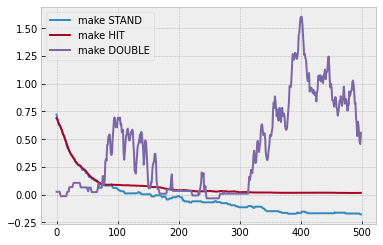

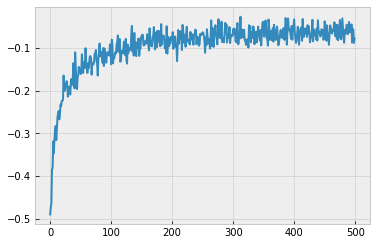

In [21]:
q_position = np.array(q_position)
plt.plot(q_position[:,0].reshape(-1, 10_000).mean(axis=1), label='make STAND')
plt.plot(q_position[:,1].reshape(-1, 10_000).mean(axis=1), label='make HIT')
plt.plot(q_position[:,2].reshape(-1, 10_000).mean(axis=1), label='make DOUBLE')
plt.legend()
plt.show()

plt.plot(np.array(q_learn_res).reshape(-1, 10_000).mean(axis=1))
plt.show();